# train lenet-5 on MNIST using fp32

In [1]:
import numpy as np
import tensorflow as tf
from dataset import load_mnist
from tensorflow import keras
from keras import layers

# load dataset
x_train, y_train, x_test, y_test = load_mnist()

In [16]:
x = x_in = keras.layers.Input((28,28,1))

x = keras.layers.Conv2D(16, kernel_size=3, padding="SAME", kernel_initializer="glorot_normal")(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(32, kernel_size=3, padding="SAME", kernel_initializer="glorot_normal")(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, kernel_initializer="glorot_normal")(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dense(256, kernel_initializer="glorot_normal")(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dense(10, kernel_initializer="glorot_normal")(x)

lenet = keras.Model(inputs=[x_in], outputs=[x])
lenet.summary()
lenet.compile(optimizer=keras.optimizers.SGD(0.01, momentum=0.9), loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.02), metrics=["accuracy"])
hist = lenet.fit(x_train, y_train, 256, 10, validation_data=(x_test, y_test))


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 re_lu_16 (ReLU)             (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 re_lu_17 (ReLU)             (None, 14, 14, 32)        0         
                                                           

# plot weight distribuiton

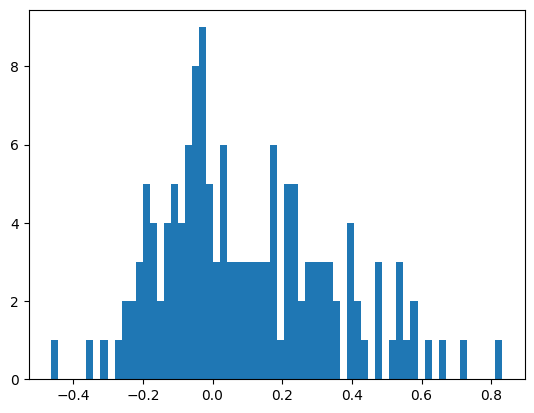

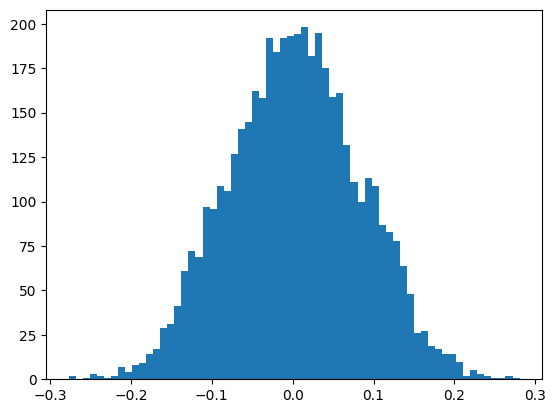

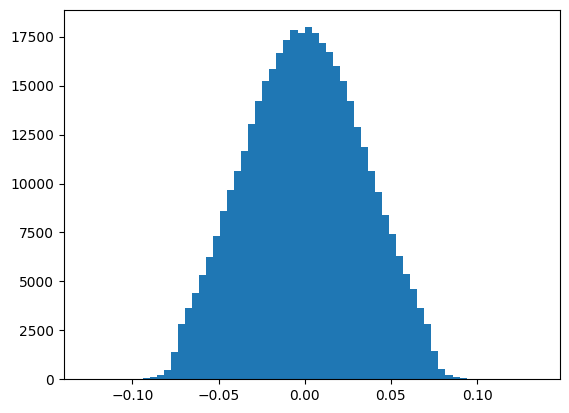

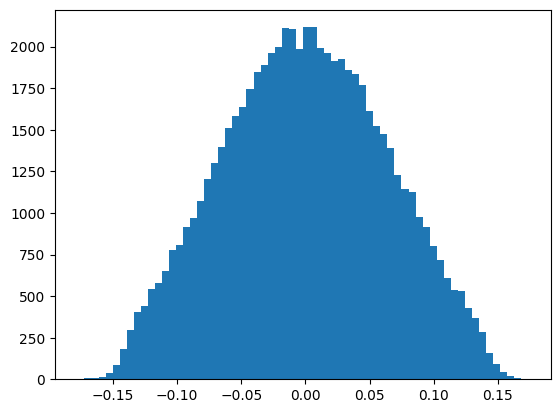

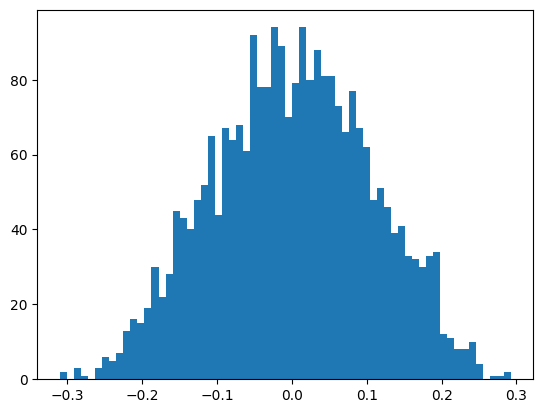

In [17]:
import matplotlib.pyplot as plt

for l in lenet.layers:
    if isinstance(l, keras.layers.Conv2D) or isinstance(l, keras.layers.Dense):
        w = l.weights[0].numpy()
        b = l.weights[1].numpy()

        plt.hist(np.ravel(w), bins=64)
        plt.show()


In [12]:
from NeuralNetwork import QNeuralNetworkWithScale, QLeNet
import Activations
import FullyConnectedLayer 


input_shape = x_train.shape[1:]

# Create and train the neural network
qlenet = QLeNet(input_shape=input_shape, output_size=y_train.shape[-1], batch_size=256)

instanciating conv layer...


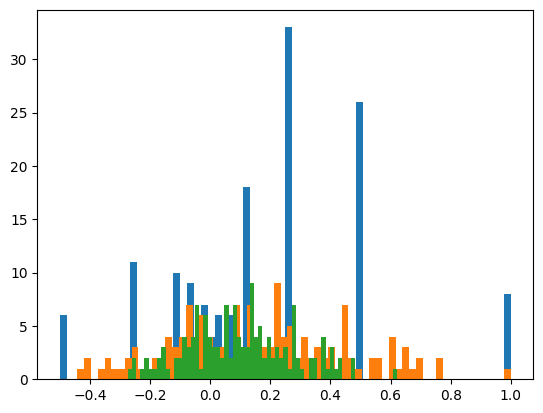

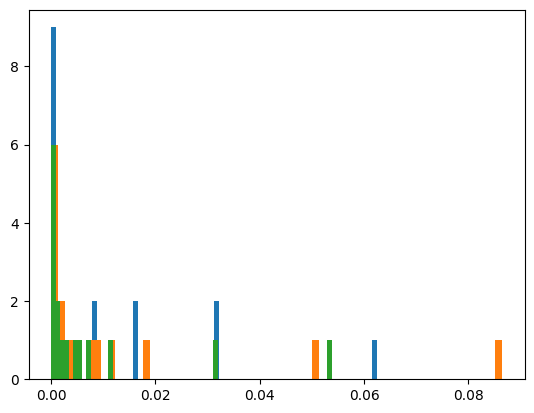

instanciating conv layer...


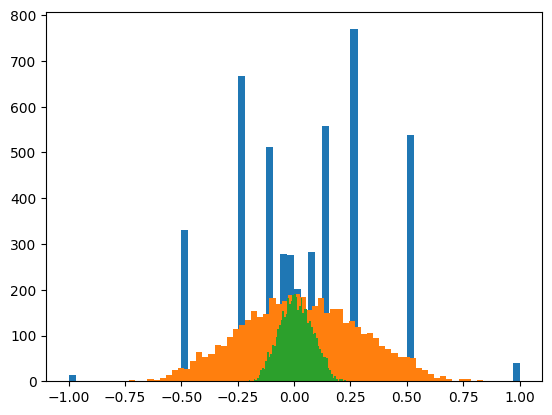

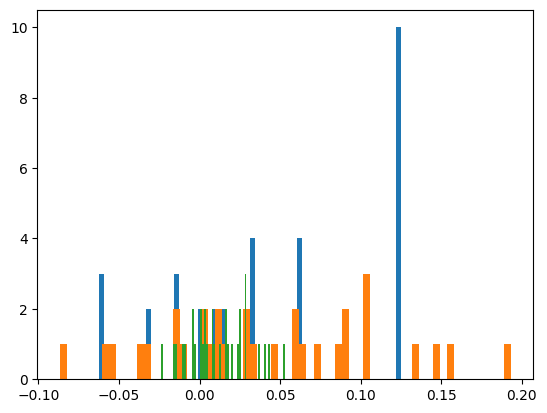

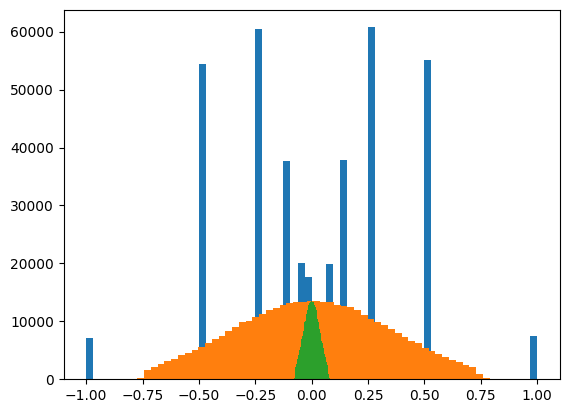

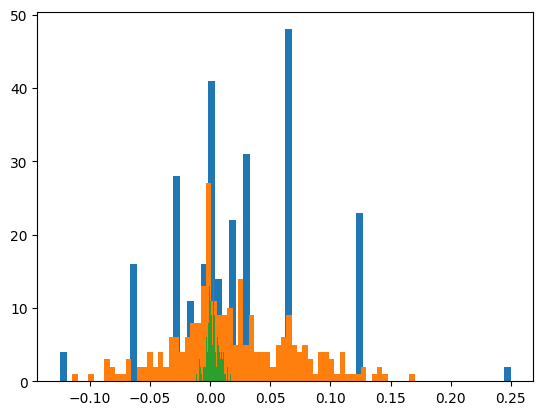

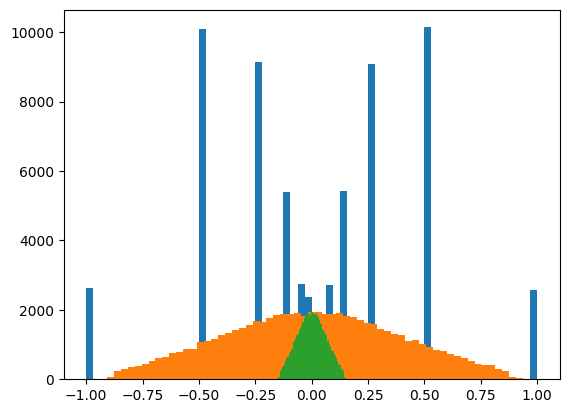

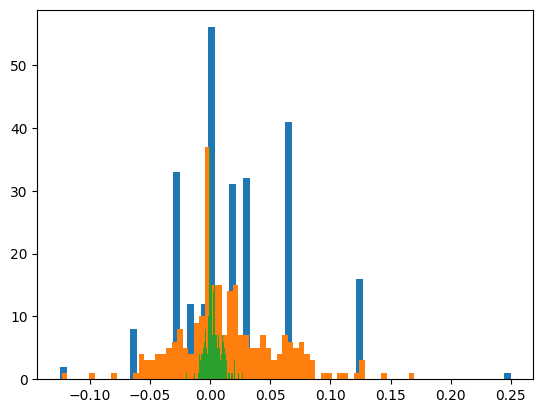

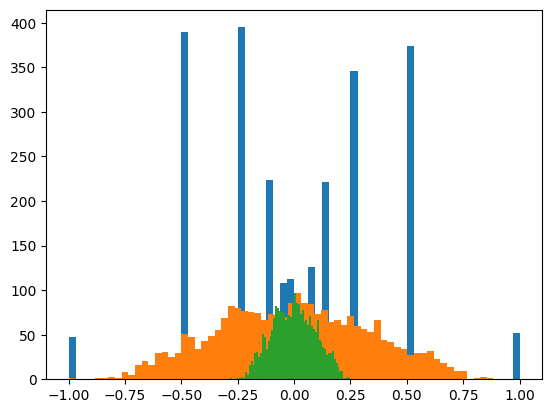

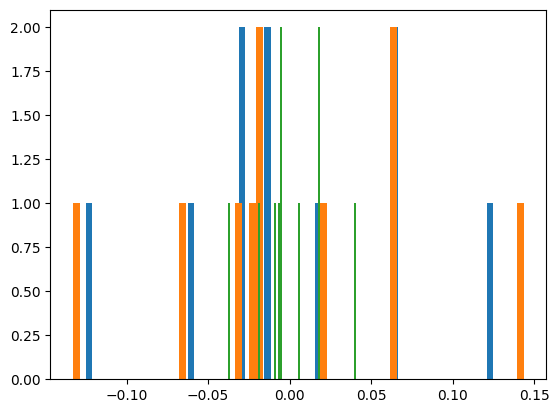

[<ConvLayer.QConvLayer object at 0x00000295EC47EA70>, <Activations.QReLU object at 0x00000295EE5A8940>, <ConvLayer.CustomMaxPool object at 0x00000295EEA231F0>, <ConvLayer.QConvLayer object at 0x00000295EE51FE20>, <Activations.QReLU object at 0x00000295F1056FE0>, <ConvLayer.CustomMaxPool object at 0x00000295F0FDBD30>, <ConvLayer.CustomFlatten object at 0x00000295EE6559C0>, <FullyConnectedLayer.QFullyConnectedLayerWithScale object at 0x000002922D954DF0>, <Activations.QReLU object at 0x000002922D7E4700>, <FullyConnectedLayer.QFullyConnectedLayerWithScale object at 0x000002922ECB1D50>, <Activations.QReLU object at 0x00000295EE917A90>, <FullyConnectedLayer.QFullyConnectedLayerWithScale object at 0x00000295EE7540D0>]


In [9]:
# como vincular um modelo com o outro?
# mais vale criar um modelo do 0 com base no modelo q vier...
# o problema maior é criar cada camada
# a rede é só um array de camadas

import matplotlib.pyplot as plt
import quantizer

from ConvLayer import *

dn_layers = []
for l in lenet.layers:
    if isinstance(l, keras.layers.Conv2D):    
        print("instanciating conv layer...")
        l.weights[0].shape[0],l.weights[0].shape[1]

        w_shape = l.weights[0].shape
        nfilters = w_shape[3]
        kernel_size = w_shape[0]
        input_channels = w_shape[2]
        strides=[1,1,1,1] ### TODO: variable strides
        padding= l.padding

        # create QCONVLAYER
        qfc = QConvLayer(nfilters, kernel_size, input_channels, strides, padding)
        
        fpw = l.weights[0].numpy()        
        fpb  = l.weights[1].numpy()
        
        w_scale = np.max(np.abs(fpw))
        
        fpw_scaled = fpw / w_scale
        qw = quantizer.quantize(fpw_scaled, True, False)
        
        # atribui o peso quantizado
        qfc.qw = qw
        qfc.weights_scale = fpw_scaled
               

        plt.hist(np.ravel(qw), bins=64)
        plt.hist(np.ravel(fpw_scaled), bins=64)
        plt.hist(np.ravel(fpw), bins=64)
        plt.show()

        
        fpb_scaled = fpb / w_scale
        qb = quantizer.quantize(fpb_scaled, True, False)
        qfc.qb = qb
        plt.hist(np.ravel(qb), bins=64)
        plt.hist(np.ravel(fpb_scaled), bins=64)
        plt.hist(np.ravel(fpb), bins=64)
        plt.show()


        dn_layers.append(qfc)

    if isinstance(l, keras.layers.MaxPool2D):    
        print(l)
        dn_maxpool = CustomMaxPool(l.pool_size, l.strides)
        dn_layers.append(dn_maxpool)

    if isinstance(l, keras.layers.Flatten):    
        dn_layers.append(CustomFlatten(l.input_shape))
    if isinstance(l, keras.layers.Dense):        
        
        qfc = FullyConnectedLayer.QFullyConnectedLayerWithScale(l.weights[0].shape[0],l.weights[0].shape[1])
        
        fpw = l.weights[0].numpy()        
        fpb  = l.weights[1].numpy()
        
        w_scale = np.max(np.abs(fpw))
        
        fpw_scaled = fpw / w_scale
        qw = quantizer.quantize(fpw_scaled, True, False)
        
        # atribui o peso quantizado
        qfc.qw = qw
        qfc.weights_scale = fpw_scaled
               

        plt.hist(np.ravel(qw), bins=64)
        plt.hist(np.ravel(fpw_scaled), bins=64)
        plt.hist(np.ravel(fpw), bins=64)
        plt.show()

        
        fpb_scaled = fpb / w_scale
        qb = quantizer.quantize(fpb_scaled, True, False)
        qfc.qb = qb
        plt.hist(np.ravel(qb), bins=64)
        plt.hist(np.ravel(fpb_scaled), bins=64)
        plt.hist(np.ravel(fpb), bins=64)
        plt.show()


        dn_layers.append(qfc)


    if isinstance(l, keras.layers.ReLU):                
        dn_layers.append(Activations.QReLU())

print(dn_layers)




In [13]:
qlenet.load_layers_from_model(lenet)

instanciating conv layer... (None, 28, 28, 16)
instanciating ReLU... (None, 28, 28, 16)
instanciating MaxPool2D... (None, 14, 14, 16)
instanciating conv layer... (None, 14, 14, 32)
instanciating ReLU... (None, 14, 14, 32)
instanciating MaxPool2D... (None, 7, 7, 32)
instanciating Flatten... (None, 1568)
instanciating Dense... (None, 256)
instanciating ReLU... (None, 256)
instanciating Dense... (None, 256)
instanciating ReLU... (None, 256)
instanciating Dense... (None, 10)


In [14]:
for i in range(20): 
    y_pred = qlenet.predict(x_test, 256)
    
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(y_pred == tf.argmax(y_test, axis=1), tf.float32))
    print(f"Accuracy: {accuracy * 100}%")

Accuracy: 97.94999694824219%
Accuracy: 98.48999786376953%
Accuracy: 98.44999694824219%
Accuracy: 98.43999481201172%
Accuracy: 98.22000122070312%
Accuracy: 98.25999450683594%
Accuracy: 98.29000091552734%
Accuracy: 98.25%
Accuracy: 98.25999450683594%
Accuracy: 98.3499984741211%
Accuracy: 98.20999908447266%
Accuracy: 98.38999938964844%
Accuracy: 98.23999786376953%
Accuracy: 98.25999450683594%
Accuracy: 98.13999938964844%
Accuracy: 98.33999633789062%
Accuracy: 98.19999694824219%
Accuracy: 98.30999755859375%
Accuracy: 98.02999877929688%
Accuracy: 98.29999542236328%


In [ ]:
# finetune the dnn
qlenet.train(x_train, y_train, learning_rate=0.000010, num_epochs=1, x_val=x_test, y_val=y_test)
